In [2]:
import json

with open("./eval.json") as f:
    d = json.load(f)

In [50]:
import pandas as pd

# Read the CSV file
df = pd.read_csv(r'human_quant.csv')

# Drop all unnamed columns
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Add a new index manually
df['index'] = 'human'  # Assuming you want a numeric index starting from 1
df.set_index('index', inplace=True)
df.index.name = None  # To remove the index name

# Modify the 'real_amount' column
df['real_amount'] = 90

# Save the modified DataFrame back to a CSV file
df.to_csv('human_quant.csv')


In [3]:
from scipy.stats import pearsonr
from scipy.stats import chisquare
from scipy.stats import entropy
from scipy.stats import wasserstein_distance

import seaborn as sns
import json
import pandas as pd
import numpy as np

with open("./res.json") as f:
    df = pd.DataFrame(json.load(f))

with open("./res.json") as f:
    d = json.load(f)

In [4]:
df.head()

,id,subject_id,img_id,time,question,short_answer,reasoned_answer
0,1.0,1.0,sample_001,538.0,What time does the photo is taken?,Approximately at afternoon around 1 PM,Because it is very sunny and there is no exist...
1,2.0,1.0,sample_001,538.0,Why the man carrying a purple backpack?,Because he is carrying things for the baby,"The man is pushing a stroller, which indicates..."
2,3.0,1.0,sample_001,538.0,Why there is a lobster logo on the middle food...,Because it is selling a lobster,Because there is a lobster logo on it.
3,4.0,1.0,sample_001,538.0,What thing is between the pillars?,A tree,Because the shapes is like a tree with many le...
4,5.0,1.0,sample_001,538.0,What is the object on top of the gate?,Black statues,Because there is an abstract formation on the ...


In [3]:


def gen_dist_analysis(test_names, output_dir="output"):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    with open("./res.json") as f:
        d = json.load(f)
    
    q_bins = np.arange(0, 21, 1.25)
    a_bins = np.arange(0, 26, 1.25)
    r_bins = np.arange(0, 51, 2.5)
    
    data = d

    # Create subplots with Seaborn for human data
    fig_h, axes_h = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    fig_h.patch.set_facecolor('white')
    
    # Create histograms using seaborn for human data
    hist_q_human = sns.histplot([len(item["question"].split()) for item in data], ax=axes_h[0], bins=q_bins, color="red")
    hist_a_human = sns.histplot([len(item["short_answer"].split()) for item in data], ax=axes_h[1], bins=a_bins, color="red")
    hist_r_human = sns.histplot([len(item["reasoned_answer"].split()) for item in data], ax=axes_h[2], bins=r_bins, color="red")
    
    # Set titles for human data histograms
    axes_h[0].set_title("Question Word Length (Human)")
    axes_h[1].set_title("Short Answer Word Length (Human)")
    axes_h[2].set_title("Reasoned Answer Word Length (Human)")
    fig_h.suptitle("Human", y=1.05)
    
    # Save human data figure to file
    human_img_path = os.path.join(output_dir, "human_histograms.png")
    fig_h.savefig(human_img_path, bbox_inches='tight')
    plt.close(fig_h)
    
    res = []
    img_paths = [human_img_path]
    for sample_name in test_names:
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
        fig.patch.set_facecolor('white')

        with open(f"../{sample_name}/res.json") as f:
            d = json.load(f)
        
        data = d
        hist_q = sns.histplot([len(item["question"].split()) for item in data], ax=axes[0], bins=q_bins)
        hist_a = sns.histplot([len(item["short_answer"].split()) for item in data], ax=axes[1], bins=a_bins)
        hist_r = sns.histplot([len(item["reasoned_answer"].split()) for item in data], ax=axes[2], bins=r_bins)
    
        # Set titles for sample data histograms
        axes[0].set_title("Question Word Length")
        axes[1].set_title("Short Answer Word Length")
        axes[2].set_title("Reasoned Answer Word Length")
        fig.suptitle(sample_name, y=1.05)
        
        sample_img_path = os.path.join(output_dir, f"{sample_name}_histograms.png")
        fig.savefig(sample_img_path, bbox_inches='tight')
        img_paths.append(sample_img_path)
        plt.close(fig)
    
        # Extract histogram data
        heights_q_human = [patch.get_height() for patch in hist_q_human.patches]
        heights_a_human = [patch.get_height() for patch in hist_a_human.patches]
        heights_r_human = [patch.get_height() for patch in hist_r_human.patches]
        
        heights_q_sample = [patch.get_height() for patch in hist_q.patches]
        heights_a_sample = [patch.get_height() for patch in hist_a.patches]
        heights_r_sample = [patch.get_height() for patch in hist_r.patches]
        
        # Add a small constant to avoid zeros
        epsilon = 1e-10
        heights_q_human = np.array(heights_q_human)
        heights_a_human = np.array(heights_a_human)
        heights_r_human = np.array(heights_r_human)
        
        heights_q_sample = np.array(heights_q_sample)
        heights_a_sample = np.array(heights_a_sample)
        heights_r_sample = np.array(heights_r_sample)
        
        pearson_corr_q, _ = pearsonr(heights_q_human, heights_q_sample)
        pearson_corr_a, _ = pearsonr(heights_a_human, heights_a_sample)
        pearson_corr_r, _ = pearsonr(heights_r_human, heights_r_sample)
        
        chi2_q, p_q = chisquare(heights_q_human + epsilon, heights_q_sample + epsilon)
        chi2_a, p_a = chisquare(heights_a_human + epsilon, heights_a_sample + epsilon)
        chi2_r, p_r = chisquare(heights_r_human + epsilon, heights_r_sample + epsilon)
        
        kl_divergence_q = entropy(heights_q_human + epsilon, heights_q_sample + epsilon)
        kl_divergence_a = entropy(heights_a_human + epsilon, heights_a_sample + epsilon)
        kl_divergence_r = entropy(heights_r_human + epsilon, heights_r_sample + epsilon)
        
        content = {
            "experiment": sample_name,
            "pearson_q": pearson_corr_q,
            "pearson_a": pearson_corr_a,
            "pearson_r": pearson_corr_r,
            "chi2_q": chi2_q,
            "chi2_a": chi2_a,
            "chi2_r": chi2_r,
            "chi2_pvalue_q": p_q,
            "chi2_pvalue_a": p_a,
            "chi2_pvalue_r": p_r,
            "kl_q": kl_divergence_q,
            "kl_a": kl_divergence_a,
            "kl_r": kl_divergence_r,
        }
        res.append(content)
    
    # Concatenate all saved images vertically using numpy
    images = [Image.open(img_path) for img_path in img_paths]
    min_width = min(img.size[0] for img in images)
    resized_images = [img.resize((min_width, int(img.size[1] * min_width / img.size[0]))) for img in images]
    image_arrays = [np.array(img) for img in resized_images]
    concatenated_image_array = np.vstack(image_arrays)
    concatenated_image = Image.fromarray(concatenated_image_array)
    
    concatenated_img_path = os.path.join(output_dir, "concatenated_histograms.png")
    concatenated_image.save(concatenated_img_path)
    
    res_df = pd.DataFrame(res)
    res_df.to_csv(os.path.join(output_dir, "hist_similarity.csv"), index=False)
    
    return pd.DataFrame(res), concatenated_img_path



In [34]:
import seaborn as sns
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter
from PIL import Image
import os

def gen_prefix_analysis(test_names, output_dir="output"):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Gather question prefixes from human data
    with open("./res.json") as f:
        human_data = json.load(f)
    
    human_prefixes = [item["question"].split()[0] for item in human_data]
    prefix_counter = Counter(human_prefixes)

    # Gather question prefixes from sample data
    for sample_name in test_names:
        with open(f"../{sample_name}/res.json") as f:
            sample_data = json.load(f)
        
        sample_prefixes = [item["question"].split()[0] for item in sample_data]
        prefix_counter.update(sample_prefixes)

    # Create a unique color mapping for each prefix
    unique_prefixes = list(prefix_counter.keys())
    colors = sns.color_palette("hls", len(unique_prefixes))
    color_mapping = {prefix: color for prefix, color in zip(unique_prefixes, colors)}

    # Number of datasets (human + samples)
    num_datasets = len(test_names) + 1

    # Determine the number of rows needed for the subplots (2 columns)
    num_rows = (num_datasets + 1) // 2

    # Plot the prefixes in pie charts, ordered by the total count across all tests
    fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(15, 5 * num_rows))
    fig.patch.set_facecolor('white')
    axes = axes.flatten()

    all_data = [("Human", human_prefixes)]
    for sample_name in test_names:
        with open(f"../{sample_name}/res.json") as f:
            sample_data = json.load(f)
        sample_prefixes = [item["question"].split()[0] for item in sample_data]
        all_data.append((sample_name, sample_prefixes))

    for i, (name, prefixes) in enumerate(all_data):
        prefix_counts = Counter(prefixes)
        sorted_prefixes = sorted(prefix_counts.items(), key=lambda x: (-prefix_counter[x[0]], -x[1]))

        labels, sizes = zip(*sorted_prefixes)
        colors = [color_mapping[label] for label in labels]
        
        axes[i].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')
        axes[i].set_title(f"{name} Question Prefix Distribution")
        axes[i].set_facecolor('white')

    # Hide any unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    pie_chart_path = os.path.join(output_dir, "prefix_pie_charts.png")
    plt.savefig(pie_chart_path)
    plt.close(fig)

    return pie_chart_path



In [35]:
TEST_NAMES = [
    "10-4_vicuna7_naive-optim_500",
    "10-4_vicuna13_naive-optim_500",
    "10-4_vicuna13-vip_nonvis-optim_500",
    "vicuna13_1.6_self-const-limit"
]

# merge_hist_simil(TEST_NAMES)
gen_prefix_analysis(TEST_NAMES)

'output/prefix_pie_charts.png'

In [4]:
d

[{'id': 1.0,
  'subject_id': 1.0,
  'img_id': 'sample_001',
  'time': 538.0,
  'question': 'What time does the photo is taken?',
  'short_answer': 'Approximately at afternoon around 1 PM',
  'reasoned_answer': 'Because it is very sunny and there is no existence of cloud'},
 {'id': 2.0,
  'subject_id': 1.0,
  'img_id': 'sample_001',
  'time': 538.0,
  'question': 'Why the man carrying a purple backpack?',
  'short_answer': 'Because he is carrying things for the baby',
  'reasoned_answer': 'The man is pushing a stroller, which indicates apparent existence of a baby then he carries the things to clean up the baby'},
 {'id': 3.0,
  'subject_id': 1.0,
  'img_id': 'sample_001',
  'time': 538.0,
  'question': 'Why there is a lobster logo on the middle food truck?',
  'short_answer': 'Because it is selling a lobster',
  'reasoned_answer': 'Because there is a lobster logo on it.'},
 {'id': 4.0,
  'subject_id': 1.0,
  'img_id': 'sample_001',
  'time': 538.0,
  'question': 'What thing is between 

In [3]:
import pandas as pd

df = pd.DataFrame(d)

In [6]:
df = pd.read_csv('human.csv', sep = ';')
df = df.rename(columns = {'logical': 'logic','irrelevancy':'irrelevance'})

In [7]:
new_d = {
    
}

for metric in ["accuracy", "logic", "clarity", "detail", "irrelevance"]:
    if metric == "irrelevance":
        new_d["avg_relevancy"] = 4 - df[metric].mean()
    elif metric == "logic":
        new_d["avg_logical"] = df[metric].mean()
    else:
        new_d[f"avg_{metric}"] = df[metric].mean()

In [8]:
new_d

{'avg_accuracy': 2.8222222222222224,
 'avg_logical': 2.7888888888888888,
 'avg_clarity': 2.8555555555555556,
 'avg_detail': 2.933333333333333,
 'avg_relevancy': 2.8777777777777778}

In [9]:
df_res = pd.DataFrame(new_d, index = ["human"])

In [10]:
df_res["gen_rate"] = 1.0
df_res["amount"] = 90
df_res["gwet_ac2"] = 1.0

In [11]:
df_res.to_csv('human_quant.csv')

In [24]:
x = ["7b_naive", "13b_naive", "vip_nonvis", "13b_1.6_self_consistency", "human"]
y = [1084/501 * 100, 1016/501 * 100, 947/401 * 100, 2660 / 200 * 100,  390.67 * 10]

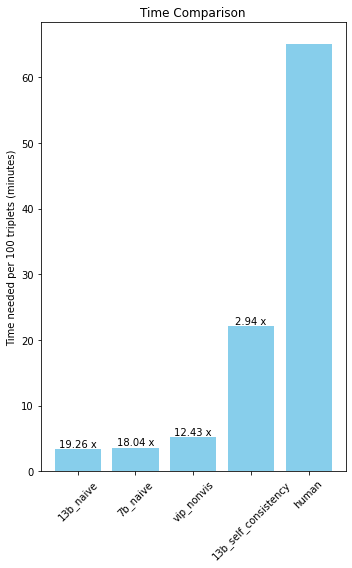

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Data
# Original lists
x = ["7b_naive", "13b_naive", "vip_nonvis", "13b_self_consistency", "human"]
y = [1084/501 * 100, 1016/501 * 100, 947/301 * 100, 2660 / 200 * 100, 390.67 * 10]
y = [np.round(i / 60, 2) for i in y]

# Zip the lists together
xy_pairs = list(zip(x, y))

# Sort the pairs based on the second element (y values)
sorted_xy_pairs = sorted(xy_pairs, key=lambda pair: pair[1])

# Unzip the sorted pairs back into two lists
sorted_x, sorted_y = zip(*sorted_xy_pairs)

# Convert the tuples back into lists
x = list(sorted_x)
y = list(sorted_y)


# Calculate the speed improvement compared to "human" time
human_time = y[-1]  # Time for "human"
speed_improvement = [(human_time / value) for value in y]

# Plotting
plt.figure(figsize=(5, 8))
bars = plt.bar(x, y, color='skyblue')

# Annotate bars with speed improvement
for bar, improvement in zip(bars[:-1], speed_improvement[:-1]):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{improvement:.2f} x", ha='center', va='bottom')

# Labels and title
plt.ylabel('Time needed per 100 triplets (minutes)')
plt.title('Time Comparison')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()
